In [1]:
# !pip install timm
import os
import glob
import numpy as np
import cv2
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


In [2]:
class CartoonColorizationDataset(Dataset):
    def __init__(self, root_dir, split='TRAIN', image_size=256):
        # Recursively find all images in the TRAIN or TEST folders
        self.image_paths = glob.glob(os.path.join(root_dir, 'cartoon_classification', split, '**', '*.jpg')) + \
                           glob.glob(os.path.join(root_dir, 'cartoon_classification', split, '**', '*.png'))
        self.image_size = image_size
        self.transforms = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(), # Converts to [0, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Open image and convert to RGB (ensure 3 channels)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.image_size, self.image_size), Image.Resampling.BILINEAR)
        img_np = np.array(img)

        # RGB to Lab conversion
        # Lab values: L [0, 100], a [-128, 127], b [-128, 127] approximately
        img_lab = color.rgb2lab(img_np)
        
        # Normalize L to [0, 1] for input
        img_l = img_lab[:, :, 0] / 100.0 
        
        # Normalize ab to [-1, 1] range for stability (approximate)
        img_ab = img_lab[:, :, 1:] / 128.0 

        # Convert to Tensor [C, H, W]
        img_l = torch.from_numpy(img_l).unsqueeze(0).float() # [1, 256, 256]
        img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float() # [2, 256, 256]

        return img_l, img_ab

# Usage on Kaggle
DATA_PATH = "/kaggle/input/cartoon-classification"
train_dataset = CartoonColorizationDataset(DATA_PATH, split='TRAIN')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

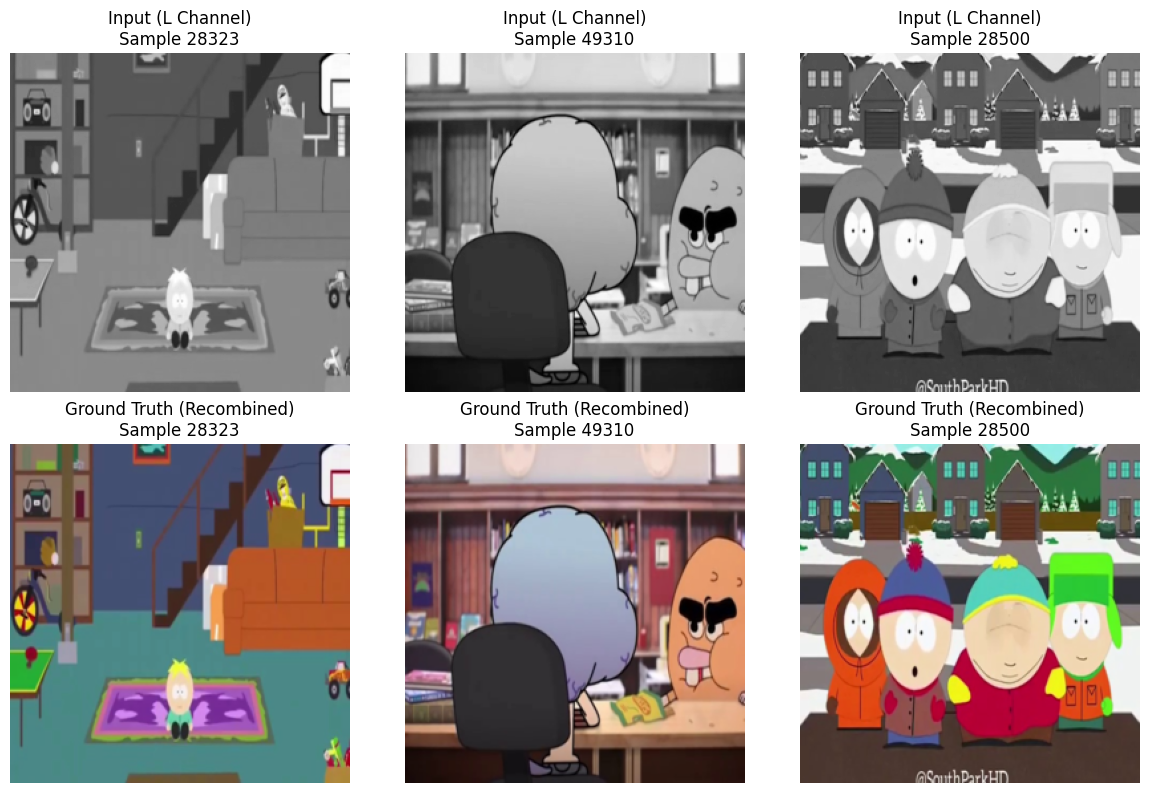

In [3]:
def visualize_preprocessed_samples(dataset, num_samples=3):
    """
    Visualizes L (Input) and reconstructed RGB (Ground Truth) from the dataset.
    """
    # Create a figure with 2 rows (Input, Ground Truth) and 'num_samples' columns
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 8))
    
    # Randomly select indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        l_tensor, ab_tensor = dataset[idx]
        
        # --- Process L Channel (Input) ---
        # Shape: [1, H, W] -> [H, W]
        l_img = l_tensor.squeeze().numpy() 
        # Display grayscale requires no conversion, just correct cmap
        axes[0, i].imshow(l_img, cmap='gray')
        axes[0, i].set_title(f"Input (L Channel)\nSample {idx}")
        axes[0, i].axis('off')

        # --- Process Lab to RGB (Ground Truth) ---
        # 1. Denormalize
        l_orig = l_img * 100.0
        ab_orig = ab_tensor.numpy() * 128.0 # Shape: [2, H, W]
        
        # 2. Stack to create Lab image [H, W, 3]
        lab_img = np.zeros((256, 256, 3))
        lab_img[:, :, 0] = l_orig
        lab_img[:, :, 1:] = ab_orig.transpose(1, 2, 0)
        
        # 3. Convert Lab -> RGB using skimage
        # Note: lab2rgb expects float64, and output is [0, 1]
        rgb_img = color.lab2rgb(lab_img)
        
        axes[1, i].imshow(rgb_img)
        axes[1, i].set_title(f"Ground Truth (Recombined)\nSample {idx}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
# Make sure 'train_dataset' is defined from the previous step
visualize_preprocessed_samples(train_dataset, num_samples=3)

In [4]:
class Backbone(nn.Module):
    def __init__(self, model_name='convnext_tiny'):
        super().__init__()
        # features_only=True returns intermediate feature maps
        self.model = timm.create_model(model_name, pretrained=True, features_only=True, in_chans=3)
        
        # Determine channel counts for the stages we need
        # ConvNeXt usually outputs stride 4, 8, 16, 32
        dummy = torch.randn(1, 3, 256, 256)
        feats = self.model(dummy)
        self.chans = [f.shape[1] for f in feats] 
        # e.g., tiny: [96, 192, 384, 768]
    
    def forward(self, x):
        # Input x is Grayscale [B, 1, H, W]. ConvNeXt expects RGB.
        # We repeat the grayscale channel 3 times.
        x = x.repeat(1, 3, 1, 1)
        return self.model(x)

In [5]:
class PixelDecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # PixelShuffle upscales by 2x. Input channels must be out_c * (2^2)
        self.conv = nn.Conv2d(in_c, out_c * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        return self.act(self.pixel_shuffle(self.conv(x)))

class PixelDecoder(nn.Module):
    def __init__(self, encoder_chans, dec_chans=[256, 128, 64]):
        super().__init__()
        self.dec_chans = dec_chans
        
        # Define upsampling blocks adapting to encoder channels
        # Note: This is a simplified UNet-style integration
        self.up4 = PixelDecoderBlock(encoder_chans[3], dec_chans[0]) 
        self.up3 = PixelDecoderBlock(dec_chans[0] + encoder_chans[2], dec_chans[1])
        self.up2 = PixelDecoderBlock(dec_chans[1] + encoder_chans[1], dec_chans[2])
        self.up1 = PixelDecoderBlock(dec_chans[2] + encoder_chans[0], dec_chans[2]) # Keep dim
        
        # Final projection to Image Embedding Ei [C, H, W]
        self.final = nn.Conv2d(dec_chans[2], 256, kernel_size=1) 

    def forward(self, feats):
        # feats: [f0(1/4), f1(1/8), f2(1/16), f3(1/32)]
        x = self.up4(feats[3]) 
        
        # Resize to match skip connection if necessary (handling odd dims)
        if x.shape != feats[2].shape: x = F.interpolate(x, size=feats[2].shape[2:])
        x = torch.cat([x, feats[2]], dim=1)
        x = self.up3(x)

        if x.shape != feats[1].shape: x = F.interpolate(x, size=feats[1].shape[2:])
        x = torch.cat([x, feats[1]], dim=1)
        x = self.up2(x)
        
        if x.shape != feats[0].shape: x = F.interpolate(x, size=feats[0].shape[2:])
        x = torch.cat([x, feats[0]], dim=1)
        x = self.up1(x)
        
        return self.final(x)

In [6]:
class ColorDecoder(nn.Module):
    def __init__(self, in_channels, num_queries=100, hidden_dim=256, n_heads=4):
        super().__init__()
        self.num_queries = num_queries
        
        # 1. Projection layer to match Backbone channels to Transformer dim
        self.projection = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        
        # 2. Learnable color queries
        self.queries = nn.Parameter(torch.zeros(1, num_queries, hidden_dim))
        
        # 3. Transformer Decoder
        self.transformer_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim*4, batch_first=True
        )
        self.transformer = nn.TransformerDecoder(self.transformer_layer, num_layers=3)
        
    def forward(self, img_features):
        # img_features: [B, 768, H/32, W/32]
        
        # Project channels: [B, 768, H, W] -> [B, 256, H, W]
        img_features = self.projection(img_features)
        
        # Flatten spatial dims: [B, 256, H, W] -> [B, 256, H*W] -> [B, H*W, 256]
        B, C, H, W = img_features.shape
        memory = img_features.view(B, C, -1).permute(0, 2, 1) 
        
        # Expand queries: [1, 100, 256] -> [B, 100, 256]
        queries = self.queries.repeat(B, 1, 1) 
        
        # Apply Transformer
        out = self.transformer(queries, memory) 
        return out

In [7]:
class DDColor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone()
        
        # Pixel Decoder (Handles upsampling)
        self.pixel_decoder = PixelDecoder(self.backbone.chans)
        
        # Color Decoder (Handles color queries)
        # We pass the number of channels from the last backbone layer (e.g., 768)
        self.color_decoder = ColorDecoder(in_channels=self.backbone.chans[-1])
        
        # Fusion Layer
        self.fusion_conv = nn.Conv2d(100, 2, kernel_size=1)
        
    def forward(self, x_l):
        # 1. Backbone features
        feats = self.backbone(x_l)
        
        # 2. Pixel Decoder -> [B, 256, H, W]
        img_emb = self.pixel_decoder(feats)
        
        # 3. Color Decoder -> [B, 100, 256]
        # Uses the deepest feature map (feats[-1])
        color_queries = self.color_decoder(feats[-1]) 
        
        # 4. Fusion (Dot Product Attention)
        B, C, H, W = img_emb.shape
        # Flatten image embeddings: [B, 256, H*W]
        img_emb_flat = img_emb.view(B, C, -1)
        
        # Matrix Multiplication: 
        # [B, 100, 256] x [B, 256, H*W] -> [B, 100, H*W]
        attention_map = torch.bmm(color_queries, img_emb_flat) 
        
        # Reshape back to spatial dimensions
        attention_map = attention_map.view(B, 100, H, W)
        
        # Final prediction convolution
        out_ab = self.fusion_conv(attention_map) 
        
        # Upsample to original resolution
        out_ab = F.interpolate(out_ab, size=(256, 256), mode='bilinear')
        return out_ab

In [8]:
from tqdm.auto import tqdm  # Automatically selects notebook-friendly widget on Kaggle

# Hyperparameters
EPOCHS = 6
LR = 1e-4

# Re-initialize model/optimizer to be safe
model = DDColor().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
criterion = nn.L1Loss() 

def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs):
    model.train()
    total_loss = 0
    
    # Initialize tqdm progress bar
    # leave=True keeps the bar after completion, leave=False clears it
    loop = tqdm(loader, desc=f"Epoch [{epoch+1}/{total_epochs}]", leave=True)
    
    for l_img, ab_gt in loop:
        l_img, ab_gt = l_img.to(device), ab_gt.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        ab_pred = model(l_img)
        
        # Calculate Loss
        loss = criterion(ab_pred, ab_gt)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update the progress bar with the current loss
        loop.set_postfix(loss=loss.item())
        
    return total_loss / len(loader)

# --- Main Training Loop ---
history = []

print("Starting training...")
for epoch in range(EPOCHS):
    avg_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch, EPOCHS)
    history.append(avg_loss)
    
    # Print epoch summary (tqdm handles the real-time bar)
    print(f"Epoch {epoch+1} Complete. Average Loss: {avg_loss:.5f}")
    
    # Save checkpoint every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), f'ddcolor_cartoon_ep{epoch+1}.pth')
        print(f"Checkpoint saved: ddcolor_cartoon_ep{epoch+1}.pth")

print("Training Complete.")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Starting training...


Epoch [1/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 1 Complete. Average Loss: 0.07158


Epoch [2/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 2 Complete. Average Loss: 0.02463


Epoch [3/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 3 Complete. Average Loss: 0.01845


Epoch [4/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 4 Complete. Average Loss: 0.01568


Epoch [5/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 5 Complete. Average Loss: 0.01411
Checkpoint saved: ddcolor_cartoon_ep5.pth


Epoch [6/6]:   0%|          | 0/7477 [00:00<?, ?it/s]

Epoch 6 Complete. Average Loss: 0.01301
Training Complete.
